In [19]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

In [20]:
# import datasets
iris = datasets.load_iris()
data = iris['data']
target = iris['target']

# split dataset into train and test sets
x_train, x_valid, y_train, y_valid = train_test_split(data, target,shuffle=True)

# normalization
scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_valid = scaler.transform(x_valid)

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_valid = torch.from_numpy(x_valid).float()
y_valid = torch.from_numpy(y_valid).long()
# torch.long: 64-bit signed integer

print("x_train: {}".format(x_train.shape))
print("y_train: {}".format(y_train.shape))
print("x_valid: {}".format(x_valid.shape))
print("y_valid: {}".format(y_valid.shape))

x_train: torch.Size([112, 4])
y_train: torch.Size([112])
x_valid: torch.Size([38, 4])
y_valid: torch.Size([38])


In [21]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_valid, y_valid)

## BATCH SIZE

In [22]:
from torch.utils.data import DataLoader
from model import Net
import torch.nn as nn
import torch.optim as optim

batch_sizes = [1, 2, 4, 8, 16, 32, 64]
computational_times = []
li_losses = []
li_accs = []

for batch_size in batch_sizes:
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

    # define network
    net = Net()

    # define loss function
    criterion = nn.CrossEntropyLoss()

    # define optimization method
    optimizer = optim.SGD(net.parameters(), lr=0.01)

    # training
    num_epoch = 50
    dataloaders_dict = {
        "train": train_dataloader, 
        "val": valid_dataloader
    }
    losses = []
    accs = []

    start_time = time.time()
    for epoch in range(num_epoch):
        # print("Epoch {}/{}".format(epoch+1, num_epoch))
        # print("")

        for phase in ["train", "val"]:
            if (phase == "train"):
                net.train()

            else:
                net.eval()

            epoch_loss = 0.0
            epoch_corrects = 0

            for inputs, labels in dataloaders_dict[phase]:
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=="train"):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if (phase=="train"):
                        loss.backward()
                        optimizer.step()
                    
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds==labels.data)
            
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

            if (phase=="train"):
                losses.append(epoch_loss)
            if (phase=="val"):
                accs.append(epoch_acc)

            # print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

    li_losses.append(losses)
    li_accs.append(accs)
    computational_times.append(time.time()-start_time)

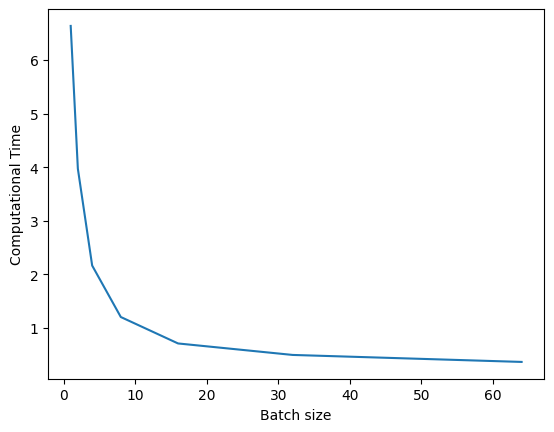

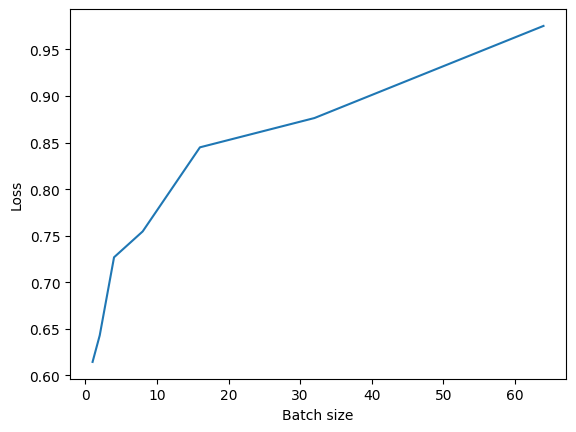

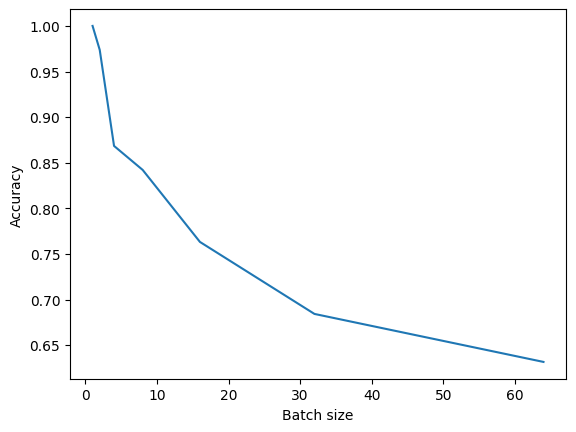

In [23]:
arr_losses = np.array(li_losses)
arr_accs = np.array(li_accs)

fig = plt.figure()
plt.plot(batch_sizes, computational_times)
plt.xlabel("Batch size")
plt.ylabel("Computational Time")
fig.savefig("./images/bs_ct.png")
plt.show()

fig = plt.figure()
plt.plot(batch_sizes, arr_losses[:, -1])
plt.xlabel("Batch size")
plt.ylabel("Loss")
fig.savefig("./images/bs_loss.png")
plt.show()

fig = plt.figure()
plt.plot(batch_sizes, arr_accs[:, -1])
plt.xlabel("Batch size")
plt.ylabel("Accuracy")
fig.savefig("./images/bs_acc.png")
plt.show()